# Clone repository and install requirements

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/kad99kev/FGTD.git

Cloning into 'FGTD'...
remote: Enumerating objects: 743, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 743 (delta 21), reused 8 (delta 8), pack-reused 721
Receiving objects: 100% (743/743), 85.16 MiB | 11.85 MiB/s, done.
Resolving deltas: 100% (393/393), done.


In [ ]:
import sys
sys.path.append('/content/FGTD/scripts')

In [ ]:
!pip install -r /content/FGTD/requirements.txt #contains the needed packages for our project

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 KB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 104.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 KB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 KB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB

# Import dependencies

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.nn import Parameter
from torch.optim.optimizer import Optimizer, required

from dataclasses import dataclass, asdict
import pandas as pd
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
import random

In [ ]:
from preprocess import get_weighted_dataloader, extract_zip
from text_encoder.sentence_encoder import SentenceEncoder

## Initializing helper functions

In [ ]:
def show_grid(img):
  npimg = img.numpy()
  global epoch
  epochs = 0
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

## Initializing constants

In [ ]:
@dataclass
class Config:
    epochs: int = 0
    batch_size: int = 16
    subset_size: int = 20_000

    noise_size: int = 100
    feature_size: int = 64
    image_size: int = 128
    save_epoch: int = 1
    num_channels: int = 3
    attention: bool = True
    
    embedding_dim: int = 768
    reduced_embedding_dim: int = 256

    g_lr: float = 0.0002
    d_lr: float = 0.0002

    device: 'typing.Any' = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
cfg = Config()
cfg_dict = asdict(cfg)


# Extracting the Dataset

CelebA dataset downloaded at my drive

unziping it to colab content


In [ ]:
# File Constants
ZIP_PATH = "/content/drive/MyDrive/archive.zip"
#ZIP_PATH = "/content/drive/MyDrive/sara_project/archive.zip"
OUTPUT_DIR = "/content/CelebA/"
epoch = 0

In [ ]:
extract_zip(ZIP_PATH, OUTPUT_DIR)

In [ ]:
OUTPUT_DIR = "/content/CelebA/img_align_celeba/img_align_celeba"

# Create Sentence Encoder

In [ ]:
sentence_encoder = SentenceEncoder(cfg.device)

  0%|          | 0.00/405M [00:00<?, ?B/s]

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/sbert.net_models_bert-base-nli-mean-tokens/0_BERT were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Create Custom Dataset Reader

In [ ]:
class ImageNTextDataset(torch.utils.data.Dataset):
    """
    Meant for CelebA Dataset'.
    Pairs True Image, True Text and Wrong Image
    """

    def __init__(self, root_dir, csv_file, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.text_df = pd.read_csv(csv_file)
        self.length = len(self.text_df)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.text_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Real Images
        img_name = os.path.join(self.root_dir, self.text_df.iloc[idx, 0])
        image = Image.open(img_name)

        true_text = random.choice(self.text_df.iloc[idx, 1:].values[0].split('\n')).strip()

        if self.transform:
            true_image = self.transform(image)

        # Wrong Images
        wrong_idx = random.randint(0, self.length - 1)
        while wrong_idx == idx:
            # To get a different index incase it is same
            wrong_idx = random.randint(0, self.length - 1)
        wrong_img_name = os.path.join(self.root_dir, self.text_df.iloc[wrong_idx, 0])
        wrong_image = Image.open(wrong_img_name)

        if self.transform:
            wrong_image = self.transform(wrong_image)

        return true_image, true_text, wrong_image

In [ ]:
n_caption_dataset = ImageNTextDataset(
    root_dir=OUTPUT_DIR, 
    csv_file='/content/FGTD/dataset/text_5_descr_celeba.csv',
    transform=transforms.Compose([transforms.Resize((cfg.image_size, cfg.image_size)), transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]),
)

# Create DataLoader

In [ ]:
weighted_dataloader, weighted_dataiter = get_weighted_dataloader(
    '/content/FGTD/dataset/list_attr_celeba.csv',  
    custom_dataset=n_caption_dataset,
    batch_size=cfg.batch_size,
    subset_size=cfg.subset_size
)

Length of random indices: 20000
Classes present:  {'Straight_Hair', 'Chubby', 'Arched_Eyebrows', 'Brown_Hair', 'Gray_Hair', 'Sideburns', 'Mustache', 'Big_Nose', 'Blond_Hair', 'Goatee', 'Pointy_Nose', 'Black_Hair', '5_o_Clock_Shadow', 'Wavy_Hair', 'Wearing_Hat', 'Wearing_Necktie', 'High_Cheekbones', 'Wearing_Lipstick', 'Bushy_Eyebrows', 'Wearing_Necklace', 'Narrow_Eyes', 'Receding_Hairline', 'Young', 'Rosy_Cheeks', 'Wearing_Earrings', 'Eyeglasses', 'Oval_Face', 'Smiling', 'Double_Chin', 'Bald', 'Pale_Skin', 'Heavy_Makeup', 'Mouth_Slightly_Open', 'Attractive', 'Big_Lips', 'Male'}
Number of classes:  36
Length of subset dataset: 20000


  0%|          | 0/20000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Using Custom Dataset Loader...


## Testing DataLoader output

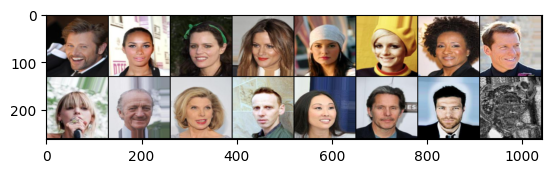

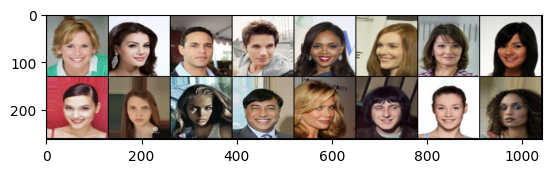

["The man has high cheekbones. He has a 5 o' clock shadow. He has brown and straight hair. He has a slightly open mouth. He is attractive and young is smiling.", 'The female has an oval face. She has straight and receding hair. She has arched eyebrows, big lips, a big nose, bushy eyebrows and a slightly open mouth. The female is attractive, young, has heavy makeup and rosy cheeks. She is wearing earrings and lipstick.', 'The woman has high cheekbones and an oval face. She has wavy hair. She has a slightly open mouth. She is smiling, seems attractive, young and has heavy makeup. She is wearing lipstick.', 'The lady has pretty high cheekbones. The lady is smiling, is attractive, young and has heavy makeup. She is wearing lipstick.', 'The woman is attractive, young and has heavy makeup. She is wearing a hat and lipstick.', 'The female has high cheekbones. Her hair is blond and straight. She has big lips and a slightly open mouth. She is smiling, is attractive, young and has pale skin. She

In [ ]:

images, labels, wrong_images = next(weighted_dataiter)
show_grid(torchvision.utils.make_grid(images, normalize=True))
show_grid(torchvision.utils.make_grid(wrong_images, normalize=True))
print(labels)

## Creating BERT sent embeddings

In [ ]:
output = sentence_encoder.convert_text_to_embeddings(labels)
print(output)
print(output.shape)

tensor([[ 0.2581,  0.0269,  0.4651,  ...,  0.4980,  0.4518, -0.2231],
        [ 0.3156, -0.1677, -0.0156,  ..., -0.3131,  0.2207,  0.0515],
        [ 0.1941, -0.4661,  0.2508,  ..., -0.4813, -0.0171,  0.2075],
        ...,
        [ 0.4891,  0.3583,  0.7325,  ...,  0.1121,  0.2404, -0.0686],
        [ 0.3720, -0.3146,  0.3992,  ...,  0.4791,  0.1196, -0.2407],
        [ 0.4785,  0.0026,  1.3073,  ...,  0.1208, -0.1483, -0.2505]],
       device='cuda:0')
torch.Size([16, 768])


## Initialize weights

In [ ]:
def initialize_weights(model):
    className = model.__class__.__name__
    if className.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif className.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

## Defining Attention Module

In [ ]:
class Self_Attn(nn.Module):
  '''
  Self attention layer
  '''
  def __init__(self, in_dim):
    super().__init__()

    self.query_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim // 2, kernel_size = 1)
    self.key_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim // 2, kernel_size = 1)
    self.value_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim, kernel_size = 1)

    self.gamma = nn.Parameter(torch.zeros(1))
    self.softmax = nn.Softmax(dim = -1)


  def forward(self, x):
    batch_size, C, width, height = x.size()
    query = self.query_conv(x).view(batch_size, -1, width * height).permute(0,2, 1)
    key = self.key_conv(x).view(batch_size, -1, width * height)
    energy = torch.bmm(query, key)

    attn = self.softmax(energy)
    value = self.value_conv(x).view(batch_size, -1, width * height)
    out = torch.bmm(value, attn.permute(0, 2, 1))
    out = out.view(batch_size, C, width, height)

    out = self.gamma * out + x
    return out, attn

In [ ]:
def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)

In [ ]:
class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

In [ ]:
class Generator(nn.Module):
  '''
  Generator architecture
  '''
  def __init__(self, noise_size, embedding_size, reduced_dim_size, num_channels, image_size, attn = True, feature_size = 64):
    super(Generator, self).__init__()
    self.attn = attn
    self.noise_dim = noise_size
    
    assert image_size in [64, 128, 256], "Can only generate images for 64, 128 and 256 dimensions."
    self.image_size = image_size

    ########## Embedding Layer ##########
    self.encode_layer = nn.Sequential(
        nn.Linear(embedding_size, reduced_dim_size),
        nn.BatchNorm1d(reduced_dim_size),
        nn.ReLU(),
        nn.Linear(reduced_dim_size, noise_size),
        nn.BatchNorm1d(noise_size),
        nn.ReLU(),
    )

    # Size 1 -> 4
    self.layer1 = nn.Sequential(
        SpectralNorm(nn.ConvTranspose2d(in_channels = noise_size, out_channels = feature_size*8, kernel_size = 4)),
        nn.BatchNorm2d(feature_size*8),
        nn.ReLU()
    )
    
    # Size 4 -> 8
    self.layer2 = nn.Sequential(
        SpectralNorm(nn.ConvTranspose2d(in_channels = feature_size*8, out_channels = feature_size*4, kernel_size = 4, stride = 2, padding = 1)),
        nn.BatchNorm2d(feature_size*4),
        nn.ReLU()
    )
    
    # Size 8 -> 16
    self.layer3 = nn.Sequential(
        SpectralNorm(nn.ConvTranspose2d(in_channels = feature_size*4, out_channels = feature_size*2, kernel_size = 4, stride = 2, padding = 1)),
        nn.BatchNorm2d(feature_size*2),
        nn.ReLU()
    )

    # Attn1 layer turn 128 dims -> 128 dims
    self.attn1 = Self_Attn(feature_size*2)
    
    # Size 16 -> 32
    self.layer4 = nn.Sequential(
        SpectralNorm(nn.ConvTranspose2d(in_channels = feature_size*2, out_channels = feature_size*2, kernel_size = 4, stride = 2, padding = 1)),
        nn.BatchNorm2d(feature_size*2),
        nn.ReLU()
    )
    
    # Attn2 layer turn 64 dims -> 64 dims
    self.attn2 = Self_Attn(feature_size*2)

    final_size = feature_size * 2
    
    if image_size >= 128:
        # Size 32 -> 64
        self.layer5 = nn.Sequential(
            SpectralNorm(nn.ConvTranspose2d(in_channels = feature_size*2, out_channels = feature_size*2, kernel_size = 4, stride = 2, padding = 1)),
            nn.BatchNorm2d(feature_size*2),
            nn.ReLU()
        )

        final_size = feature_size * 2

        # Attn3 layer turn 64 dims -> 64 dims
        self.attn3 = Self_Attn(feature_size*2)

        if image_size == 256:
            # Size 64 -> 128
            self.layer6 = nn.Sequential(
                SpectralNorm(nn.ConvTranspose2d(in_channels = feature_size*2, out_channels = feature_size, kernel_size = 4, stride = 2, padding = 1)),
                nn.BatchNorm2d(feature_size),
                nn.ReLU()
            )

            final_size = feature_size

        

    # Output last_dim -> last_dim * 2
    self.output_layer = nn.Sequential(
        nn.ConvTranspose2d(final_size, 3, 4, 2, 1),
        nn.Tanh()
    )

    self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.0002, betas = (0.5, 0.999))

  def forward(self, noise, text_embeddings):
    encoded_text = self.encode_layer(text_embeddings)
    # Concatenating the noise and encoded text
    concat_input = torch.mul(noise, encoded_text).view(-1, self.noise_dim, 1, 1)
    
    x = self.layer1(concat_input)
    x = self.layer2(x)
    x = self.layer3(x)
    if self.attn:
      x, _ = self.attn1(x)
    x = self.layer4(x)
    if self.attn:
      x, _ = self.attn2(x)
    if self.image_size >= 128:
        x = self.layer5(x)
        if self.attn:
            x, _ = self.attn3(x)
        if self.image_size == 256:
            x = self.layer6(x)
        

    x = self.output_layer(x)
    return x


In [ ]:
generator = Generator(cfg.noise_size, cfg.embedding_dim, cfg.reduced_embedding_dim, cfg.num_channels, cfg.image_size, attn=cfg.attention, feature_size=cfg.feature_size)
generator.cuda() if torch.cuda.is_available() else generator.cpu()


Generator(
  (encode_layer): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=100, bias=True)
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (layer1): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    )
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2),

torch.Size([16, 3, 128, 128])


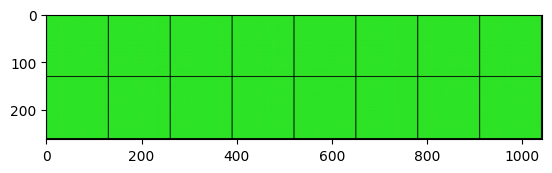

Generator(
  (encode_layer): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=100, bias=True)
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (layer1): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    )
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2),

In [ ]:
with torch.no_grad():
  generator.eval()
  noise = torch.randn(size=(cfg.batch_size, cfg.noise_size)).cuda() if torch.cuda.is_available() else torch.randn(size=(cfg.batch_size, cfg.noise_size)).cpu()
  text_embeddings = sentence_encoder.convert_text_to_embeddings(labels)
  output = generator(noise, text_embeddings).detach()
  print(output.shape)
show_grid(torchvision.utils.make_grid(output.cpu(), normalize=True))
generator.train()

In [ ]:
class Discriminator(nn.Module):
  '''
  Discriminator architecture
  '''
  def __init__(self, num_channels, feature_size, attn, image_size, embedding_size, reduced_dim_size):
    super(Discriminator, self).__init__()
    self.reduced_dim_size = reduced_dim_size
    self.attn = attn
    self.image_size = image_size

    # Size 256/128/64 -> 128/64/32
    self.layer1 = nn.Sequential(
        SpectralNorm(nn.Conv2d(num_channels, feature_size, 4, 2, 1)),
        nn.LeakyReLU(0.1)
    )
    
    # Size 128/64/32 -> 64/32/16
    self.layer2 = nn.Sequential(
        SpectralNorm(nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1)),
        nn.LeakyReLU(0.1)
    )
    feature_size = feature_size * 2
    
    # Size 64/32/16 -> 32/16/8
    self.layer3 = nn.Sequential(
        SpectralNorm(nn.Conv2d(feature_size , feature_size, 4, 2, 1)),
        nn.LeakyReLU(0.1)
    )
    
    # Attn1 layer remains the same dim and size
    self.attn1 = Self_Attn(feature_size)
    
    # Size 32/16/8 -> 16/8/4
    self.layer4 = nn.Sequential(
        SpectralNorm(nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1)),
        nn.LeakyReLU(0.1)
    )
    feature_size = feature_size * 2
    
    # Attn2 layer remains the same dim and size
    self.attn2 = Self_Attn(feature_size)

    if image_size >= 128:
        # Size 16/8 -> 8/4
        self.layer5 = nn.Sequential(
            SpectralNorm(nn.Conv2d(feature_size, feature_size, 4, 2, 1)),
            nn.LeakyReLU(0.1)
        )

        self.attn3 = Self_Attn(feature_size)

        if image_size == 256:
            # Size 8 -> 4

            self.layer6 = nn.Sequential(
                SpectralNorm(nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1)),
                nn.LeakyReLU(0.1)
            )
            
            feature_size = feature_size * 2

    ########## Text Encode ##########
    self.encode_text = nn.Sequential(
        nn.Linear(embedding_size, reduced_dim_size),
        nn.LeakyReLU(0.2, inplace=True)
    )

    ########## Text + Image Concate Layer ##########
    self.image_text_layer = nn.Sequential(
        nn.Conv2d(feature_size + reduced_dim_size, feature_size * 8, 1, 1, 0, bias=False),
        nn.BatchNorm2d(feature_size * 8),
        nn.LeakyReLU(0.2,inplace=True),
    )

    ########## Output Layer ##########
    self.output_layer = nn.Sequential(
        nn.Conv2d(feature_size * 8, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )

    self.optimizer = optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))

  def forward(self, input_images, text_embeddings):
    x = self.layer1(input_images)
    x = self.layer2(x)
    x = self.layer3(x)
    if self.attn:
      x, _ = self.attn1(x)
    x = self.layer4(x)
    if self.attn:
      x, _ = self.attn2(x)
    if self.image_size >= 128:
        x = self.layer5(x)
        if self.attn:
            x, _ = self.attn3(x)
        if self.image_size == 256:
            x = self.layer6(x)

    ## Text ##
    encoded_text = self.encode_text(text_embeddings)
    encoded_text = encoded_text.unsqueeze(2).unsqueeze(2).repeat(1, 1, 4, 4)

    ## Text + Image ##
    concat_output = self.image_text_layer(torch.cat([x, encoded_text], dim=1))
    output = self.output_layer(concat_output)

    return output.view(-1, 1)


In [ ]:
discriminator = Discriminator(cfg.num_channels, cfg.image_size, cfg.attention, cfg.image_size, cfg.embedding_dim, cfg.reduced_embedding_dim)
discriminator.cuda() if torch.cuda.is_available() else discriminator.cpu()

Discriminator(
  (layer1): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (layer2): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (layer3): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (attn1): Self_Attn(
    (query_conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-1)
  )
  (layer4): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  

In [ ]:
def load_model():
  PATH = "/content/drive/MyDrive/model_checkpoint.pth"
  if os.path.exists(PATH):
    print(f'a saved model exists')
    checkpoint = torch.load(PATH) if torch.cuda.is_available() else torch.load(PATH, map_location=torch.device('cpu'))
    epoch = checkpoint['epoch']
    generator.load_state_dict(checkpoint['generator'])
    discriminator.load_state_dict(checkpoint['discriminator'])
    generator.optimizer.load_state_dict(checkpoint['optimizerA_state_dict'])
    discriminator.optimizer.load_state_dict(checkpoint['optimizerB_state_dict'])
    print(f'model reloading')
    print(epoch)

    generator.eval()
    discriminator.eval()
  else:
     print(f'no saved model exists')
  
  

In [ ]:
load_model()

no saved model exists


In [ ]:
generator.train()

Generator(
  (encode_layer): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=100, bias=True)
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (layer1): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    )
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2),

In [ ]:
with torch.no_grad():
  discriminator.eval()
  validity = discriminator(output, text_embeddings)
  print(validity.shape)
discriminator.train()

torch.Size([16, 1])


Discriminator(
  (layer1): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (layer2): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (layer3): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (attn1): Self_Attn(
    (query_conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-1)
  )
  (layer4): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  

In [ ]:
! git clone https://github.com/sbarratt/inception-score-pytorch

In [ ]:
# calculate inception score in numpy
from numpy import asarray
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import exp
 
# calculate the inception score for p(y|x)
def calculate_inception_score(p_yx, eps=1E-16):
 # calculate p(y)
 p_y = expand_dims(p_yx.mean(axis=0), 0)
 # kl divergence for each image
 kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
 # sum over classes     
 sum_kl_d = kl_d.sum(axis=1)
 # average over images
 avg_kl_d = mean(sum_kl_d)
 # undo the logs
 is_score = exp(avg_kl_d)
 return is_score
 
# conditional probabilities for high quality images
p_yx = asarray([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]])
score = calculate_inception_score(p_yx)

print(score)

3.9999999999999982


## Plotting output after each epoch

In [ ]:
plt_images, plt_labels, plt_wrong = next(weighted_dataiter)
plt_o_text_embeddings = sentence_encoder.convert_text_to_embeddings(plt_labels)
plt_o_text_embeddings.shape

torch.Size([16, 768])

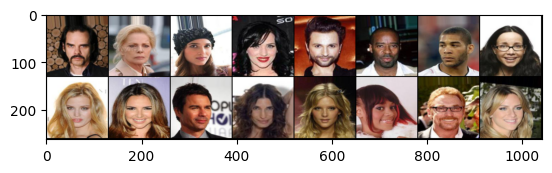

['He grows a mustache. He has black, straight and receding hair. He has a big nose and bushy eyebrows.', 'She has blond, wavy and receding hair. She has pale skin.', 'Her hair is wavy. She has arched eyebrows, big lips and bushy eyebrows. She looks attractive, young and has heavy makeup. She is wearing a hat and lipstick.', 'The woman has pretty high cheekbones. Her hair is black and wavy. She has big lips and a slightly open mouth. The lady is young, is smiling and has heavy makeup. She is wearing lipstick.', "He has a 5 o' clock shadow, wears a goatee and has sideburns. He has a big nose and a pointy nose. The man looks attractive and young.", 'The male has a chubby face, has pretty high cheekbones and an oval face. He grows a goatee. He has receding hair. He has big lips and a big nose. The male seems young.', "The gentleman has high cheekbones. He sports a 5 o' clock shadow. His hair is black and receding. He has big lips, a big nose and bushy eyebrows. The man is young.", 'The fem

In [ ]:
show_grid(torchvision.utils.make_grid(plt_images.cpu(), normalize=True))
print(plt_labels)

In [ ]:
fixed_noise = torch.randn(size=(len(plt_labels), cfg.noise_size)).cuda() if torch.cuda.is_available() else torch.randn(size=(len(plt_labels), cfg.noise_size)).cpu()


In [ ]:
def plot_output(epoch):
  plt.clf()
  with torch.no_grad():

    generator.eval()
    test_images = generator(fixed_noise, plt_o_text_embeddings)
    generator.train()
    grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
    show_grid(grid)
  


## Training

In [ ]:
adversarial_loss = nn.BCELoss().cuda()

In [ ]:
def save_model(Epoch,Loss):
   path = '/content/drive/MyDrive' 
   if os.path.exists(path):
    print(f'The file exists')
   else:
    os.mkdir(path)
    

   
   
   PATH = "/content/drive/MyDrive/model_checkpoint.pth"
   print(f'runs')
   torch.save({
            'epoch': Epoch,
            'Loss': Loss,
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'optimizerA_state_dict': generator.optimizer.state_dict(),
            'optimizerB_state_dict': discriminator.optimizer.state_dict(),
            }, PATH)


0it [00:00, ?it/s]

Epoch: 1 / 15
The file exists
runs
Discriminator Loss: 1.775, Generator Loss: 2.270


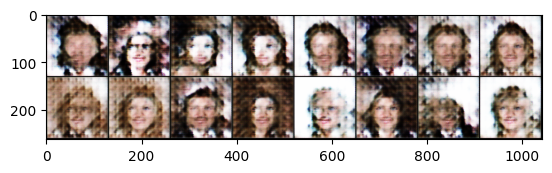

Epoch: 2 / 15
The file exists
runs
Discriminator Loss: 1.226, Generator Loss: 2.776


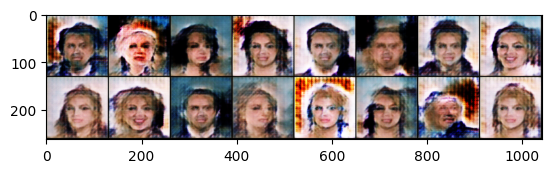

Epoch: 3 / 15
The file exists
runs
Discriminator Loss: 0.947, Generator Loss: 3.459


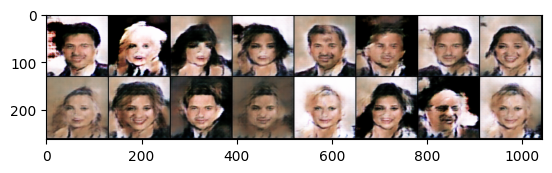

Epoch: 4 / 15
The file exists
runs
Discriminator Loss: 0.807, Generator Loss: 4.047


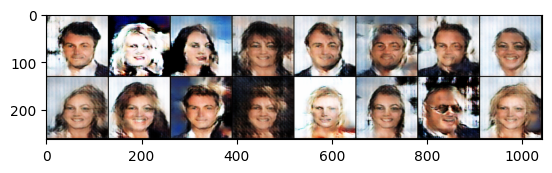

Epoch: 5 / 15
The file exists
runs
Discriminator Loss: 0.689, Generator Loss: 4.526


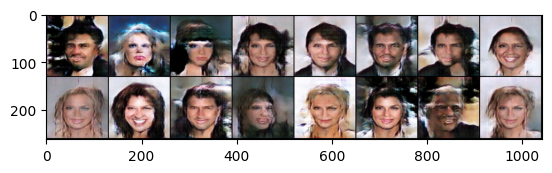

Epoch: 6 / 15
The file exists
runs
Discriminator Loss: 0.656, Generator Loss: 4.741


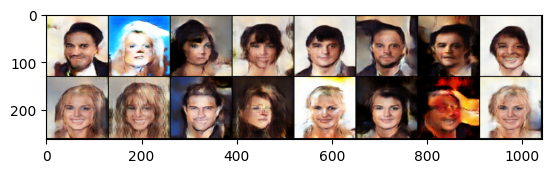

Epoch: 7 / 15
The file exists
runs
Discriminator Loss: 0.641, Generator Loss: 4.981


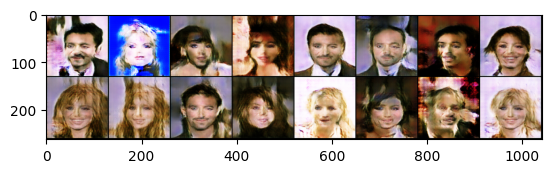

Epoch: 8 / 15
The file exists
runs
Discriminator Loss: 0.544, Generator Loss: 5.441


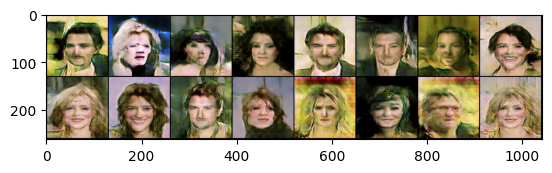

Epoch: 9 / 15
The file exists
runs
Discriminator Loss: 0.547, Generator Loss: 5.686


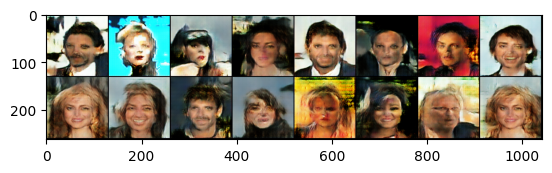

Epoch: 10 / 15
The file exists
runs
Discriminator Loss: 0.486, Generator Loss: 5.734


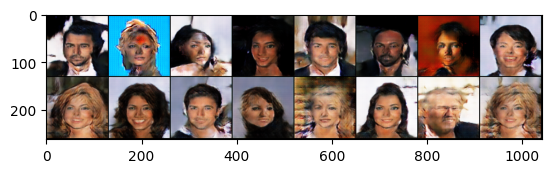

True

In [ ]:
from pickle import load
pbar = tqdm()

# Add models to wandb
#wandb.watch(generator)
#wandb.watch(discriminator)
#load_model()


#for epoch in range(cfg.epochs):

#load_model()
e=0
while (e < 10): 
   
    print(f'Epoch: {e + 1} / {15}')
    pbar.reset(total=len(weighted_dataloader))
    # Setting up losses
    discriminator_losses = []
    generator_losses = []
    save_model(e,generator_losses)
  #  for i, (real_images, real_text, wrong_images) in enumerate(weighted_dataloader):
    for i, (real_images, real_text, wrong_images) in enumerate(weighted_dataloader):
        # Current batch size
        
        current_batch_size = real_images.size()[0]

        # Convert to cuda
        real_images = real_images.cuda() if torch.cuda.is_available() else real_images.cpu()
        wrong_images = wrong_images.cuda() if torch.cuda.is_available() else wrong_images.cpu()
        text_embeddings = sentence_encoder.convert_text_to_embeddings(real_text)

        # For real vs fake
        real_validity = torch.ones(current_batch_size, 1).cuda() if torch.cuda.is_available() else torch.ones(current_batch_size, 1).cpu()
        fake_validity = torch.zeros(current_batch_size, 1).cuda() if torch.cuda.is_available() else torch.zeros(current_batch_size, 1).cpu()

        # Train Generator
        generator.zero_grad()
        input_noise = torch.randn(size=(current_batch_size, cfg.noise_size)).cuda() if torch.cuda.is_available() else torch.randn(size=(current_batch_size, cfg.noise_size)).cpu()
        fake_images = generator(input_noise, text_embeddings)
        discriminator_fake_validity = discriminator(fake_images, text_embeddings)
        generator_loss = adversarial_loss(discriminator_fake_validity, real_validity)

        generator_loss.backward()
        generator.optimizer.step()
        generator_losses.append(generator_loss)

        # Train Discriminator
        discriminator.zero_grad()

        ## To calculate real loss
        discriminator_real_validity = discriminator(real_images, text_embeddings)
        discriminator_real_loss = adversarial_loss(discriminator_real_validity, real_validity)

        ## To calculate wrong loss
        discriminator_wrong_validity = discriminator(wrong_images, text_embeddings)
        discriminator_wrong_loss = adversarial_loss(discriminator_wrong_validity, fake_validity)

        ## To calculate fake loss
        discriminator_fake_validity = discriminator(fake_images.detach(), text_embeddings)
        discriminator_fake_loss = adversarial_loss(discriminator_fake_validity, fake_validity)

        ## Calculating total loss
        discriminator_loss = discriminator_real_loss + discriminator_wrong_loss + discriminator_fake_loss
        discriminator_loss.backward()
        discriminator.optimizer.step()
        discriminator_losses.append(discriminator_loss)


        # Update tqdm
        pbar.update()
    e=e+1
    print('Discriminator Loss: {:.3f}, Generator Loss: {:.3f}'.format(
            torch.mean(torch.FloatTensor(discriminator_losses)),
            torch.mean(torch.FloatTensor(generator_losses))
            
    ))
    
#wandb.log({"generator loss" : torch.mean(torch.FloatTensor(generator_losses)), "discriminator loss" : torch.mean(torch.FloatTensor(discriminator_losses))}, step=epoch+1)
 
    #https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html
    # Specify a path to save to
    

    if (e + 1) % cfg.save_epoch == 0:
        plot_output(e+1)
        #save_model(epoch,generator_losses)
   







pbar.refresh()

## Testing

In [ ]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda() if torch.cuda.is_available() else torch.randn(size=(1, cfg.noise_size)).cpu()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['The man is chubby, has a double chin and pretty high cheekbones. He grows a sideburns. His hair is black. He has big lips and a big nose. The man looks young.'])

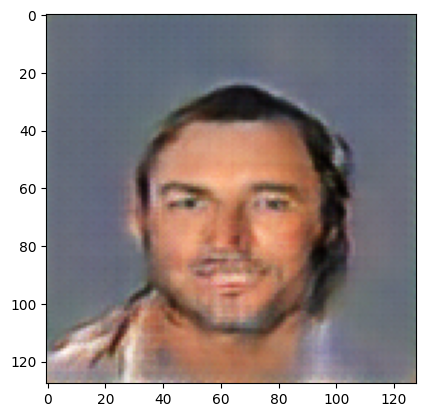

In [ ]:
generator.eval()
test_image = generator(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

In [ ]:
!pip install anvil-uplink

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 KB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45228 sha256=09e5c3c0b548a66b784bddf8b940821b71b0f3e3e6d5cfcb44d1f67c71ea3018
  Stored in directory: /root/.cache/pip/wheels/e8/9d/fd/0a594a1bc8d493935d319ac40d64d79f5b4117ef4d37b1b678
Successfully built ws4py


In [ ]:
#import anvil.server
import io
import PIL
import torchvision.transforms as T
import cv2
#anvil.server.connect("O7XRDUVHPVUG2DRPUT4SBQRY-KY2K2A4I2YBIB5LH")
#@anvil.server.callable
def face_description(desc):
 # print("Hello from the uplink, %s!" % name)
 #she is blonde wearing eyeglasses
  test_noise = torch.randn(size=(1, cfg.noise_size)).cuda() if torch.cuda.is_available() else torch.randn(size=(1, cfg.noise_size)).cpu()
  test_embeddings = sentence_encoder.convert_text_to_embeddings([desc])
  generator.eval()
  test_image = generator(test_noise, test_embeddings).detach().cpu()
  x= torchvision.utils.make_grid(test_image, normalize=True, nrow=1)
  show_grid(x)
  #media_obj = anvil.BlobMedia(content_type="image/PNG", content=img.BytesIO.getvalue)

  #return  media_obj
#anvil.server.wait_forever()

face_description("Dates")

NameError: ignored